## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Experiments on the MNIST dataset

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import scipy.io as sio
import time
import matplotlib as mpl
import os
import pickle

##### Importing modules wtitten by the author

In [2]:
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData
from NearestNeighbor import NearestNeighbor

##### Preparing matplotlib to genrate high-quality images for the paper

In [3]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 600

##### Set K=6 as in <a href="https://link.springer.com/article/10.1007/s11063-018-9906-5">Competitive Cross-Entropy Paper.</a>

In [4]:
C  = 10
K = 6
maxVqIteration = 100
L = C * K
width = 28
height = 28
N = None
NTest = None

##### Load Training and Testing Data and Normalize them

In [5]:
XTrain = sio.loadmat ('../datasets/mnist/MnistTrainX')['MnistTrainX']
yTrain = sio.loadmat ('../datasets/mnist/MnistTrainY')['MnistTrainY']
XTrain = XTrain / 255.0
if N:
    XTrain = XTrain[:N,:]
    yTrain = yTrain[:N]
    
XTest = sio.loadmat ('../datasets/mnist/MnistTestX')['MnistTestX']
yTest = sio.loadmat ('../datasets/mnist/MnistTestY')['MnistTestY']
XTest = XTest / 255.0

if NTest:
    XTest = XTest[:NTest,:]
    yTest = yTest[:NTest]

##### Prepare data for LDA.

In [6]:
np.random.seed(1)
td = TrainingData(XTrain, yTrain)

clusAlg = sklearn.cluster.KMeans(random_state=1)
clusAlg.max_iter = maxVqIteration
arrayK = np.ones(C, dtype=int)*K
start = time.time()
td.findSubclasses(arrayK, clusAlg)
end = time.time()
print ('Time for clustering: ', end - start)
filename = 'mnist_clusters.pickle'
with open(filename, 'wb') as file:
    pickle.dump(td.subclassMeans, file)

Time for clustering:  32.665772676467896


##### Show Clustering Result

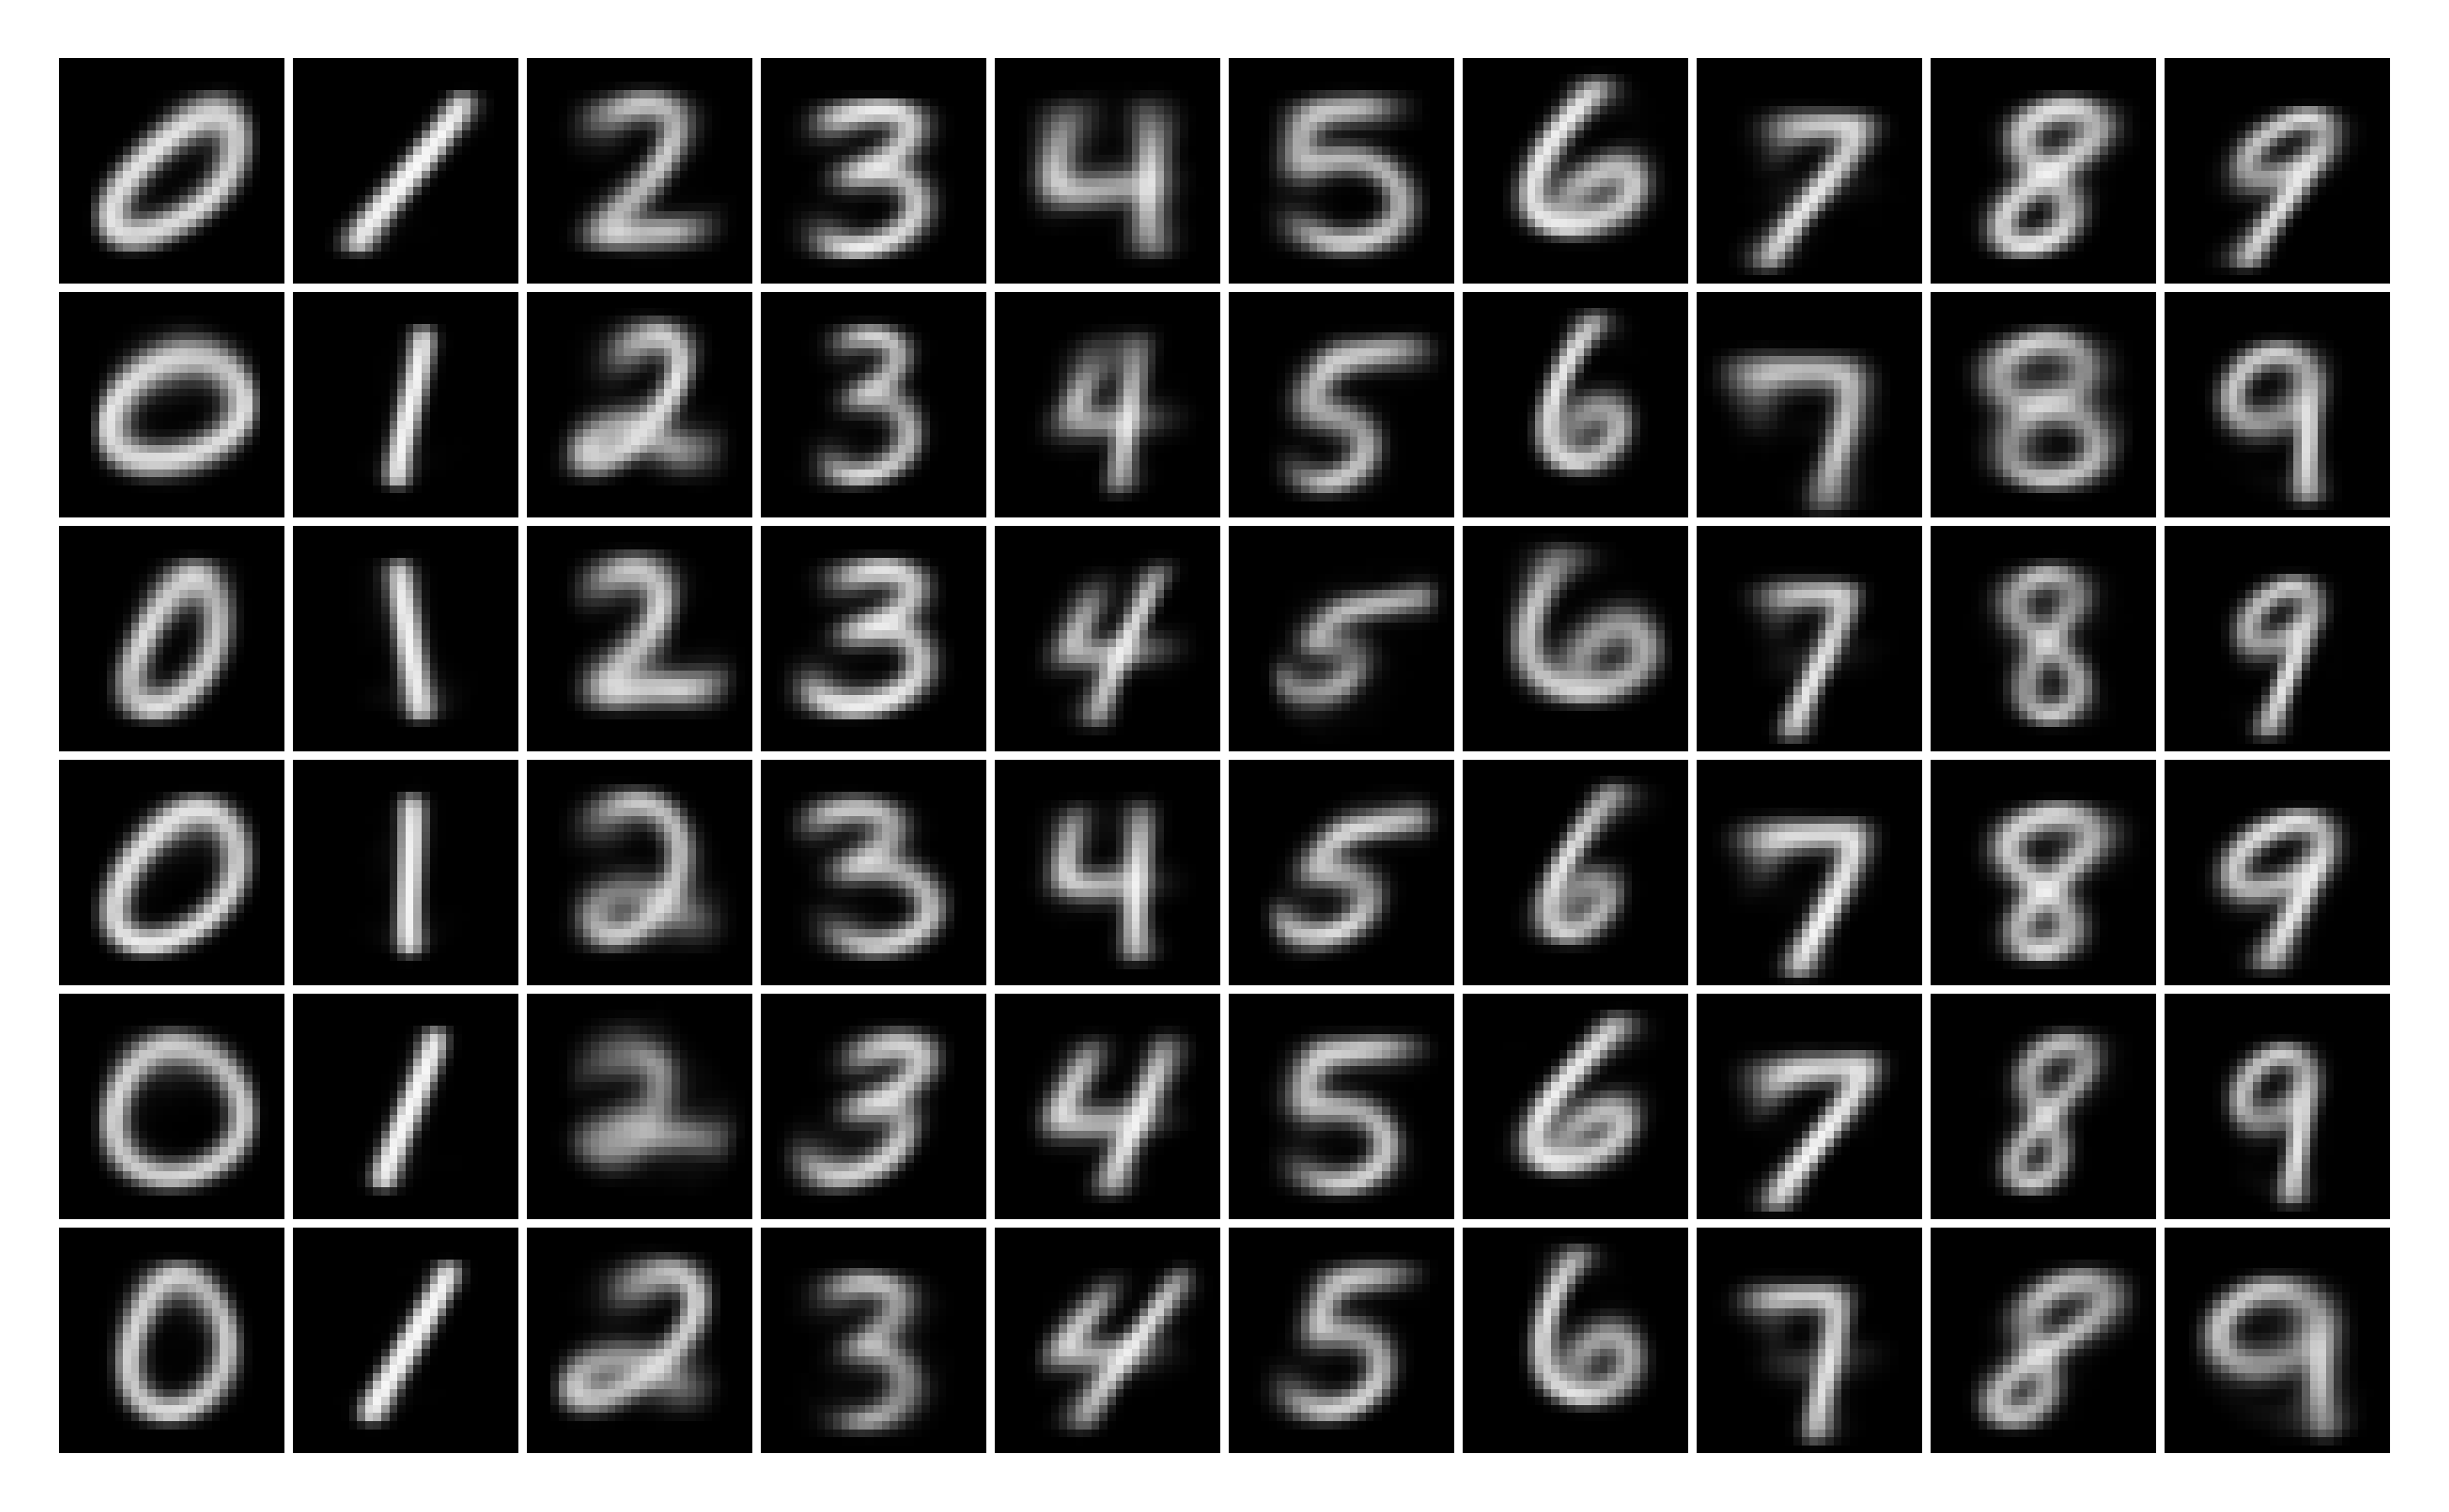

In [7]:
img = np.ones ([1+K*(height+1), 1+td.C * (width+1),3])
for c in range(td.C):
    for k in range (td.Ki[c]):
        idx1 = k*(height+1)+1
        idx2 = c*(width+1)+1
        img[idx1:idx1+height, idx2:idx2+width,0] = td.subclassMeans[c,k].reshape ([height,width])
        img[idx1:idx1+height, idx2:idx2+width,1] = img[idx1:idx1+height, idx2:idx2+width,0]
        img[idx1:idx1+height, idx2:idx2+width,2] = img[idx1:idx1+height, idx2:idx2+width,0]
plt.axis('off')
plt.imshow (img)
fn = 'mnist_clustering_reg_1_0' + '.png'
plt.imsave(fn, img)        
plt.show()

##### The function for performing an experiment. 

In [8]:
def performExperiment (solver, S2, reg, options):
    print ('solver = ', solver, ' regularions parameter = ', reg)
    lda = LinearDiscriminantAnalysis(td, solver, 'Sb', S2, reg, 0.0001)
    
    start = time.time()
    lda.fitFeatureExtractor()
    end = time.time()
    print ('lda.fitFeatureExtractor took time: ', end - start)
    
    if solver == 'orthogonal_centroid':
        lda.solver = 'eigen'
        
    objective = lda.objective()
    print('Objective: ' , objective)
    
    objective2 = lda.objective2()
    print('Objective(SecondMethod): ' , objective2)    
        
    if 'NN' in options:
        print('***Classification results based on Nearest Neighbor classifier***')        
        start = time.time()
        XTrainFtr = lda.transform (XTrain)
        XTestFtr  = lda.transform (XTest)
        acc = NearestNeighbor (XTrainFtr, yTrain, XTestFtr, yTest)
        end = time.time()
        print ('classification by NearestNeighbor took time: ', end - start)
        print ('Accuracy of Nearest Neighbor classifier is: ', acc)   
    
    if 'Bayes' in options:
        # Compute classification error
        print('***Classification results based on Bayes optimal classifier***')
        start = time.time()
        lda.fitBayesLinearClassifier()
        yHat = lda.classifyByBayesClassifier(XTest)
        end = time.time()
        print ('lda.classifyByBayesLinearClassifier took time: ', end - start)
        yHat = np.array(yHat, dtype='int')
        outVal = sklearn.metrics.accuracy_score(yTest, yHat)
        print('Test classification error: ' + str(outVal))
    
    if 'Max' in options:        
        print('***Classification results based on max output***')
        yHat = lda.classifyByMaxClassifier(XTest)
        yHat = np.array(yHat, dtype='int')
        outVal = sklearn.metrics.accuracy_score(yTest, yHat)
        print('Test classification error: ' + str(outVal))
        
    if 'Depict' in options:
        img = lda.GenerateImagesOfLinearFeatureExtractorWeights(width, height, color = 'gray', nImages=1, rows=K, cols = C)
        plt.axis('off')
        plt.imshow (img[0])
        fn = 'mnist_{}_reg_1_0'.format(solver) + '.png'
        plt.imsave(fn, img[0])       
        plt.show()
        
    if solver == 'orthogonal_centroid':
        lda.solver = 'orthogonal_centroid'
        
    #return lda

##### For solver='eigen', S2=St and S2=Sw should return the same result

solver =  eigen  regularions parameter =  1
lda.fitFeatureExtractor took time:  1.9400436878204346
Objective:  7.347679154525615
Objective(SecondMethod):  7.347679154212849
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  278.81275963783264
Accuracy of Nearest Neighbor classifier is:  0.9724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  2.0058507919311523
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145


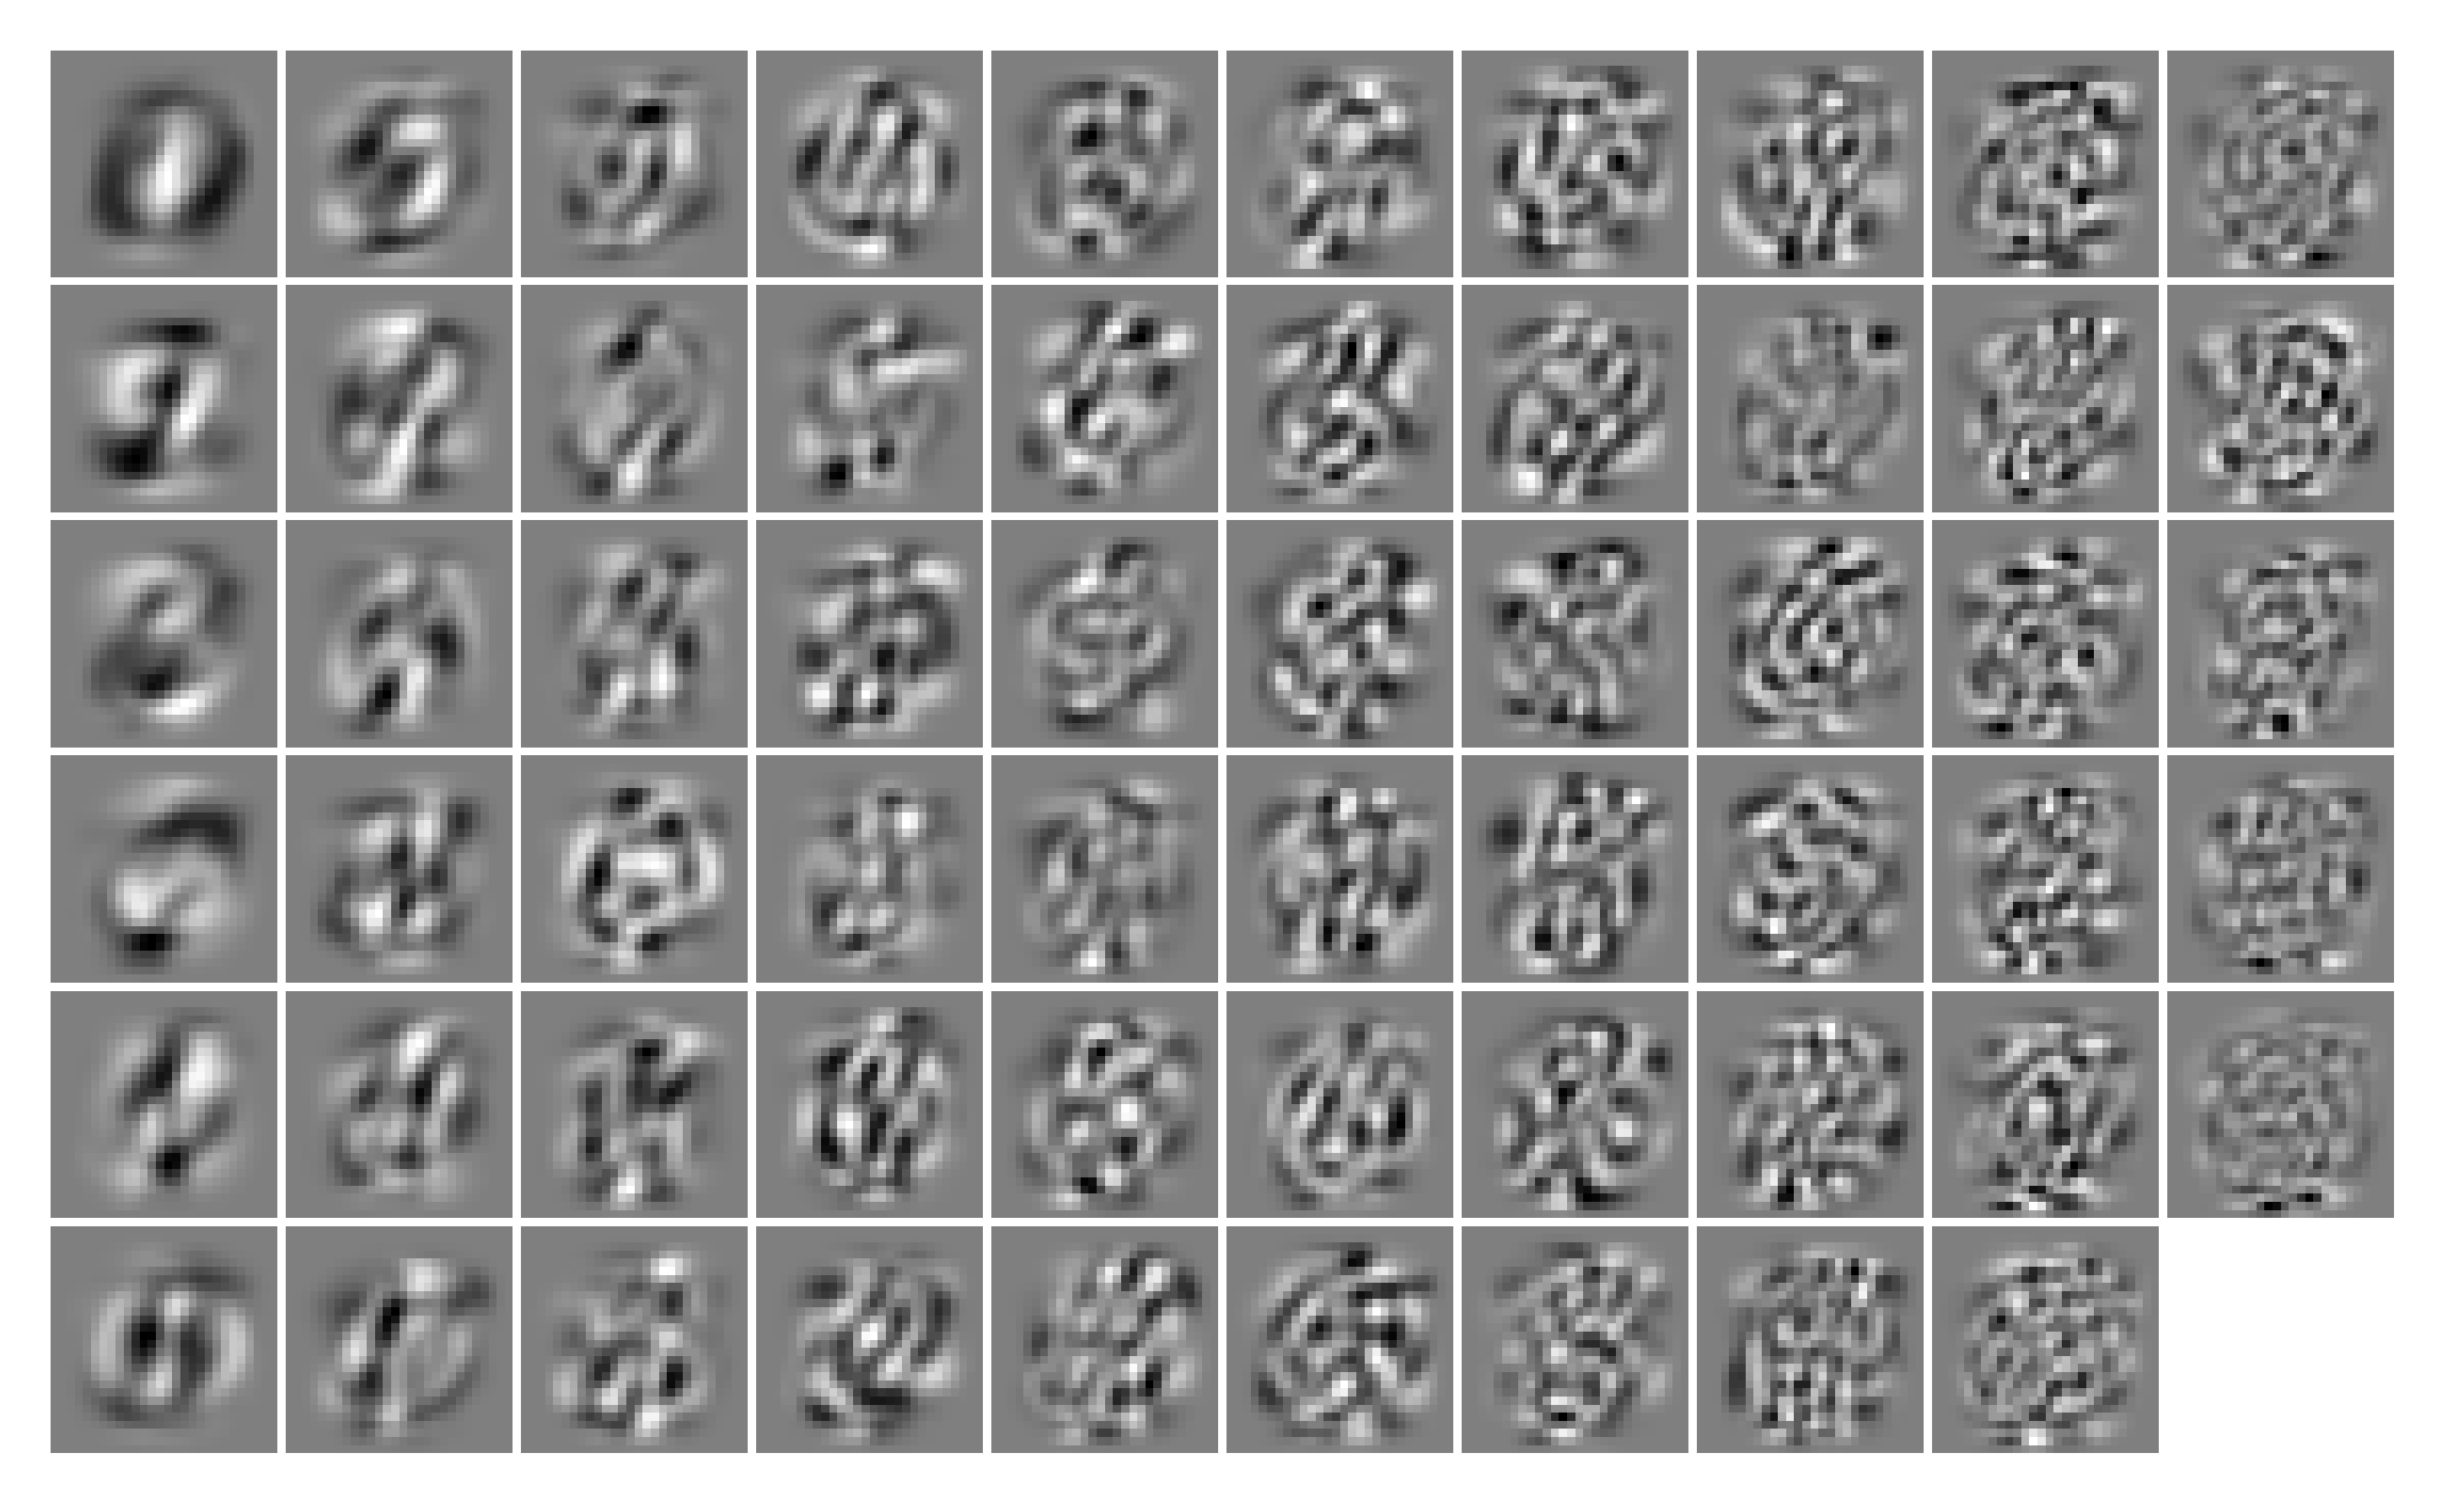

In [9]:
options = ['NN', 'Bayes', 'Max', 'Depict']
#options = ['Bayes', 'Max']
performExperiment ('eigen', S2='St', reg=1, options=options)

solver =  eigen  regularions parameter =  1
lda.fitFeatureExtractor took time:  1.3774290084838867
Objective:  7.347679154525617
Objective(SecondMethod):  7.347679154212849
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  273.8777434825897
Accuracy of Nearest Neighbor classifier is:  0.9724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  0.9376792907714844
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145


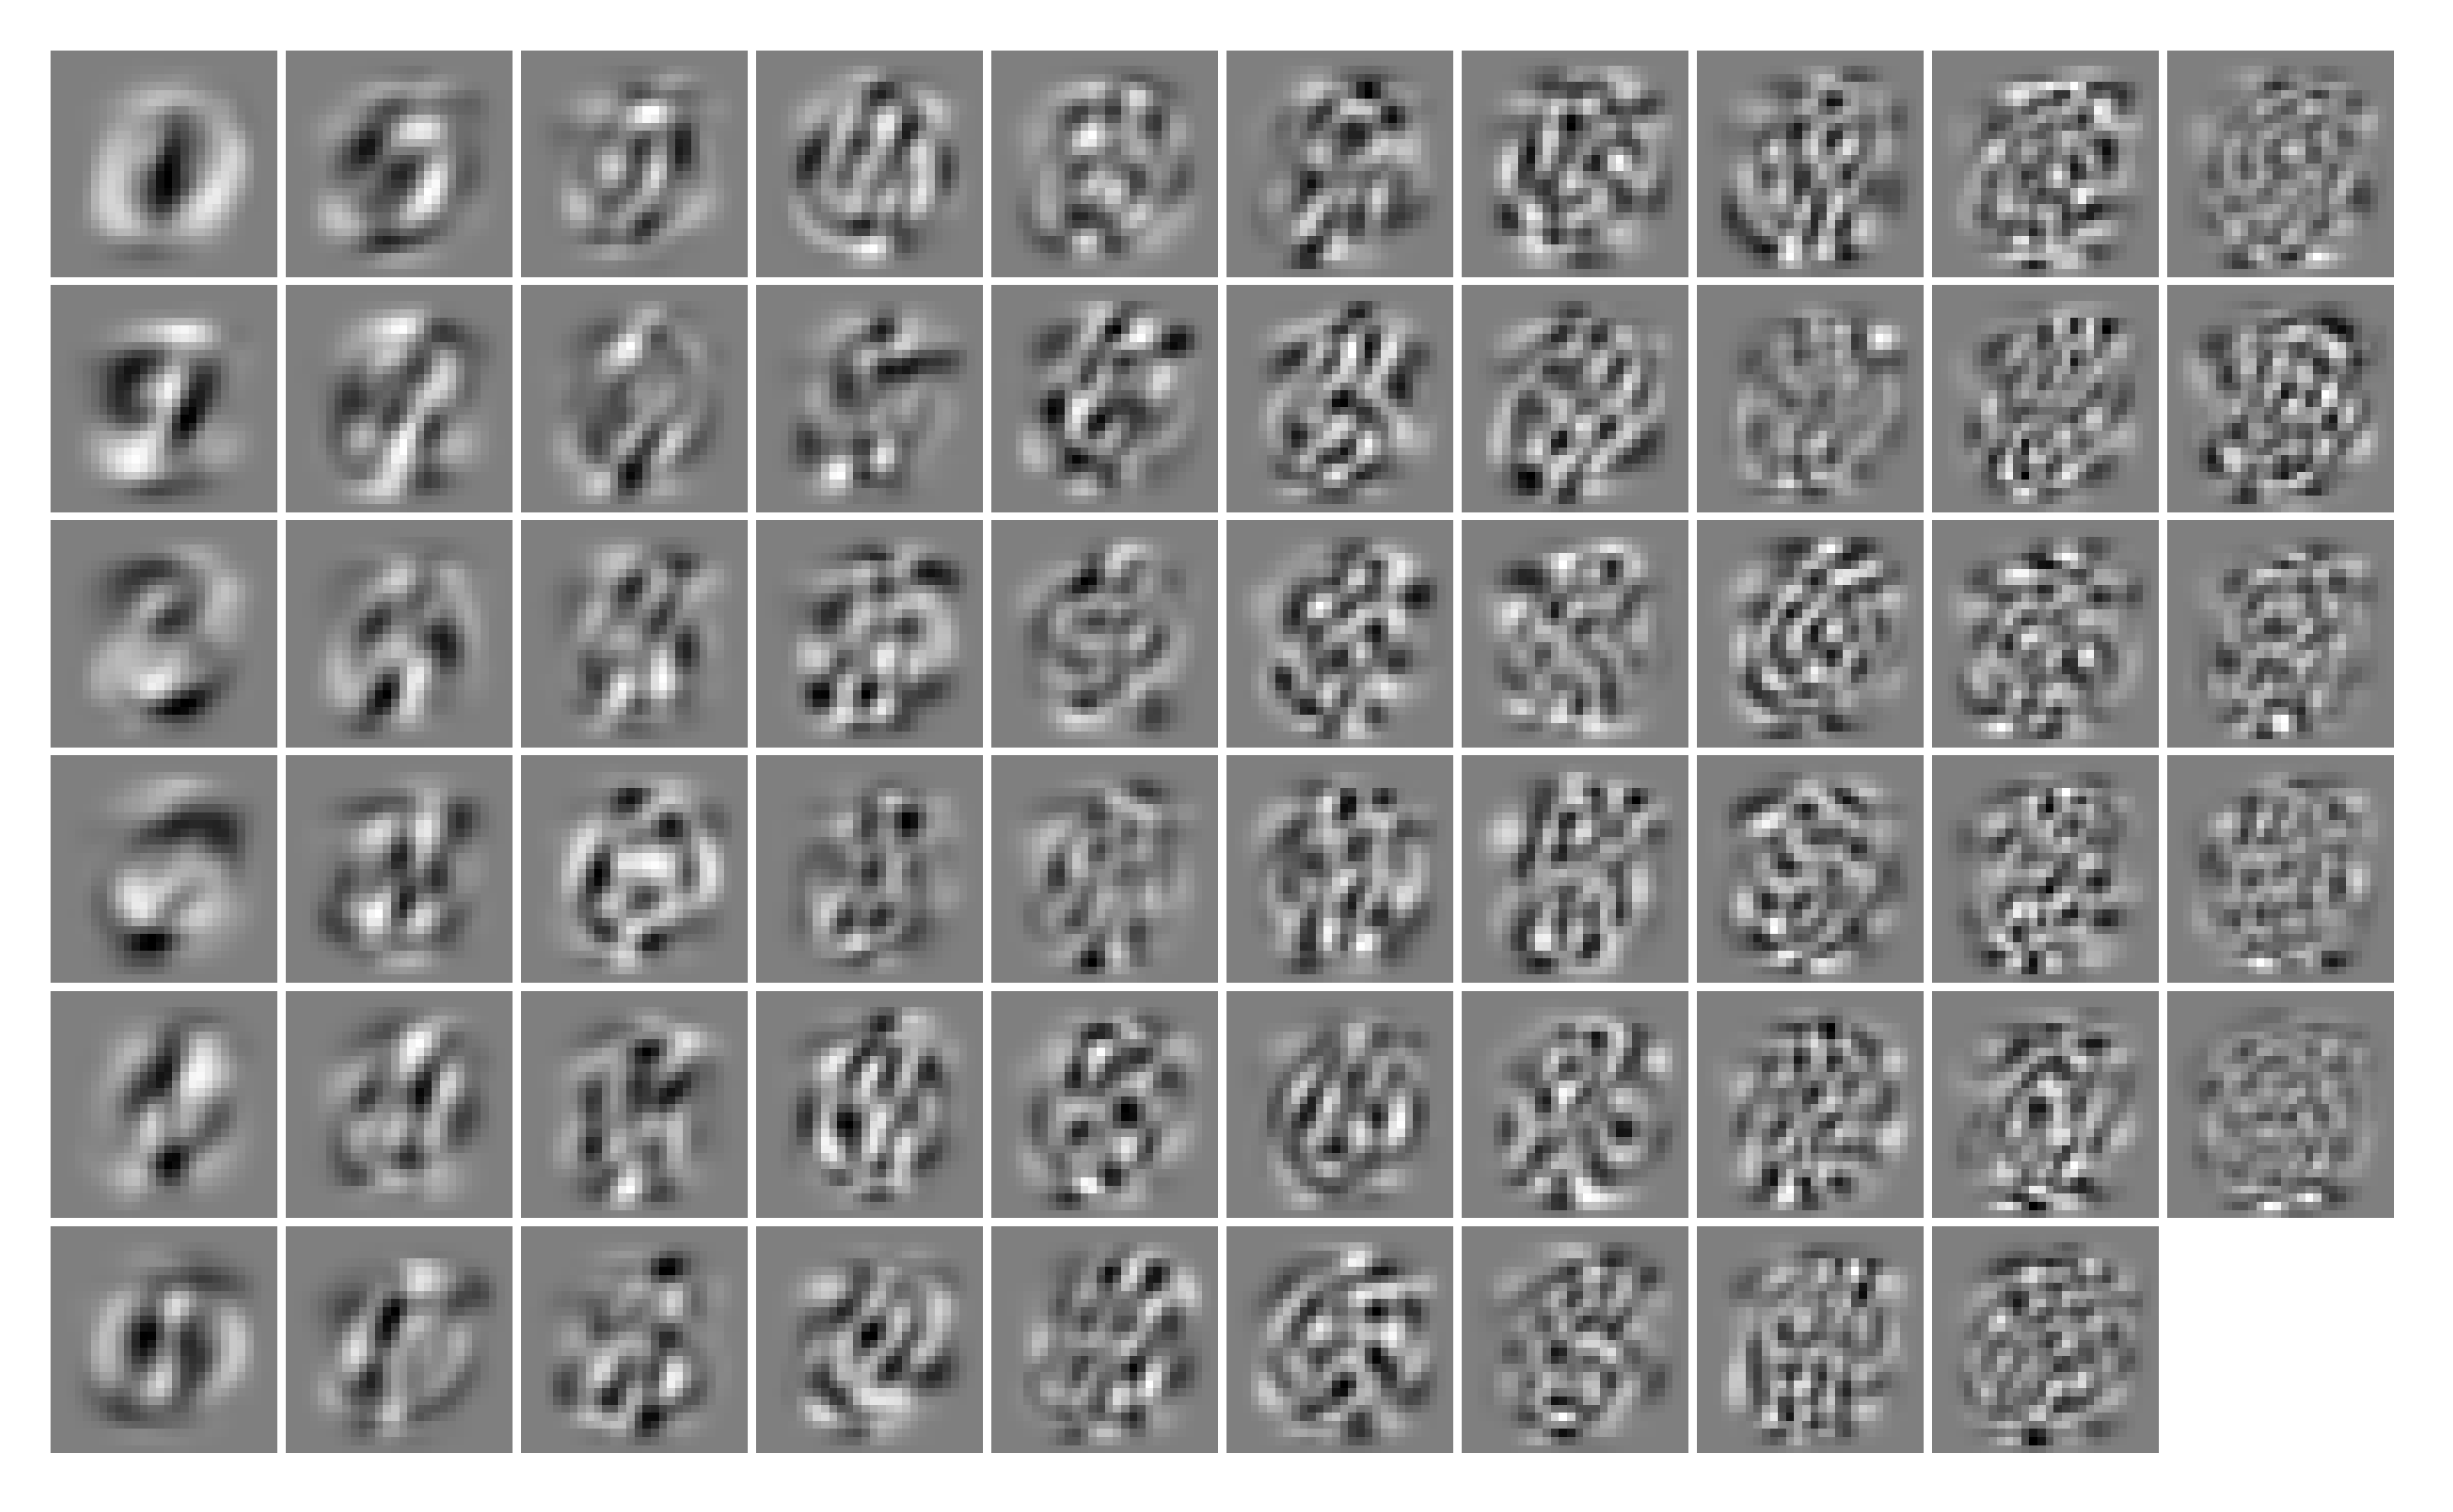

In [10]:
performExperiment ('eigen', S2='Sw', reg=1, options=options)

##### Repeating the above experiments using the proposed method ('ghiasi_lstsq')
In the proposed method, we should always use S2=St.
We expect the objective value to be the same as traditional LDA (above).
However, the learned feature extractors are hightly interpretable

solver =  ghiasi_lstsq  regularions parameter =  1
lda.fitFeatureExtractor took time:  1.845137357711792
Objective:  7.3476791545255695
Objective(SecondMethod):  7.347679153682236
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  263.8570613861084
Accuracy of Nearest Neighbor classifier is:  0.9709
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.6659047603607178
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145


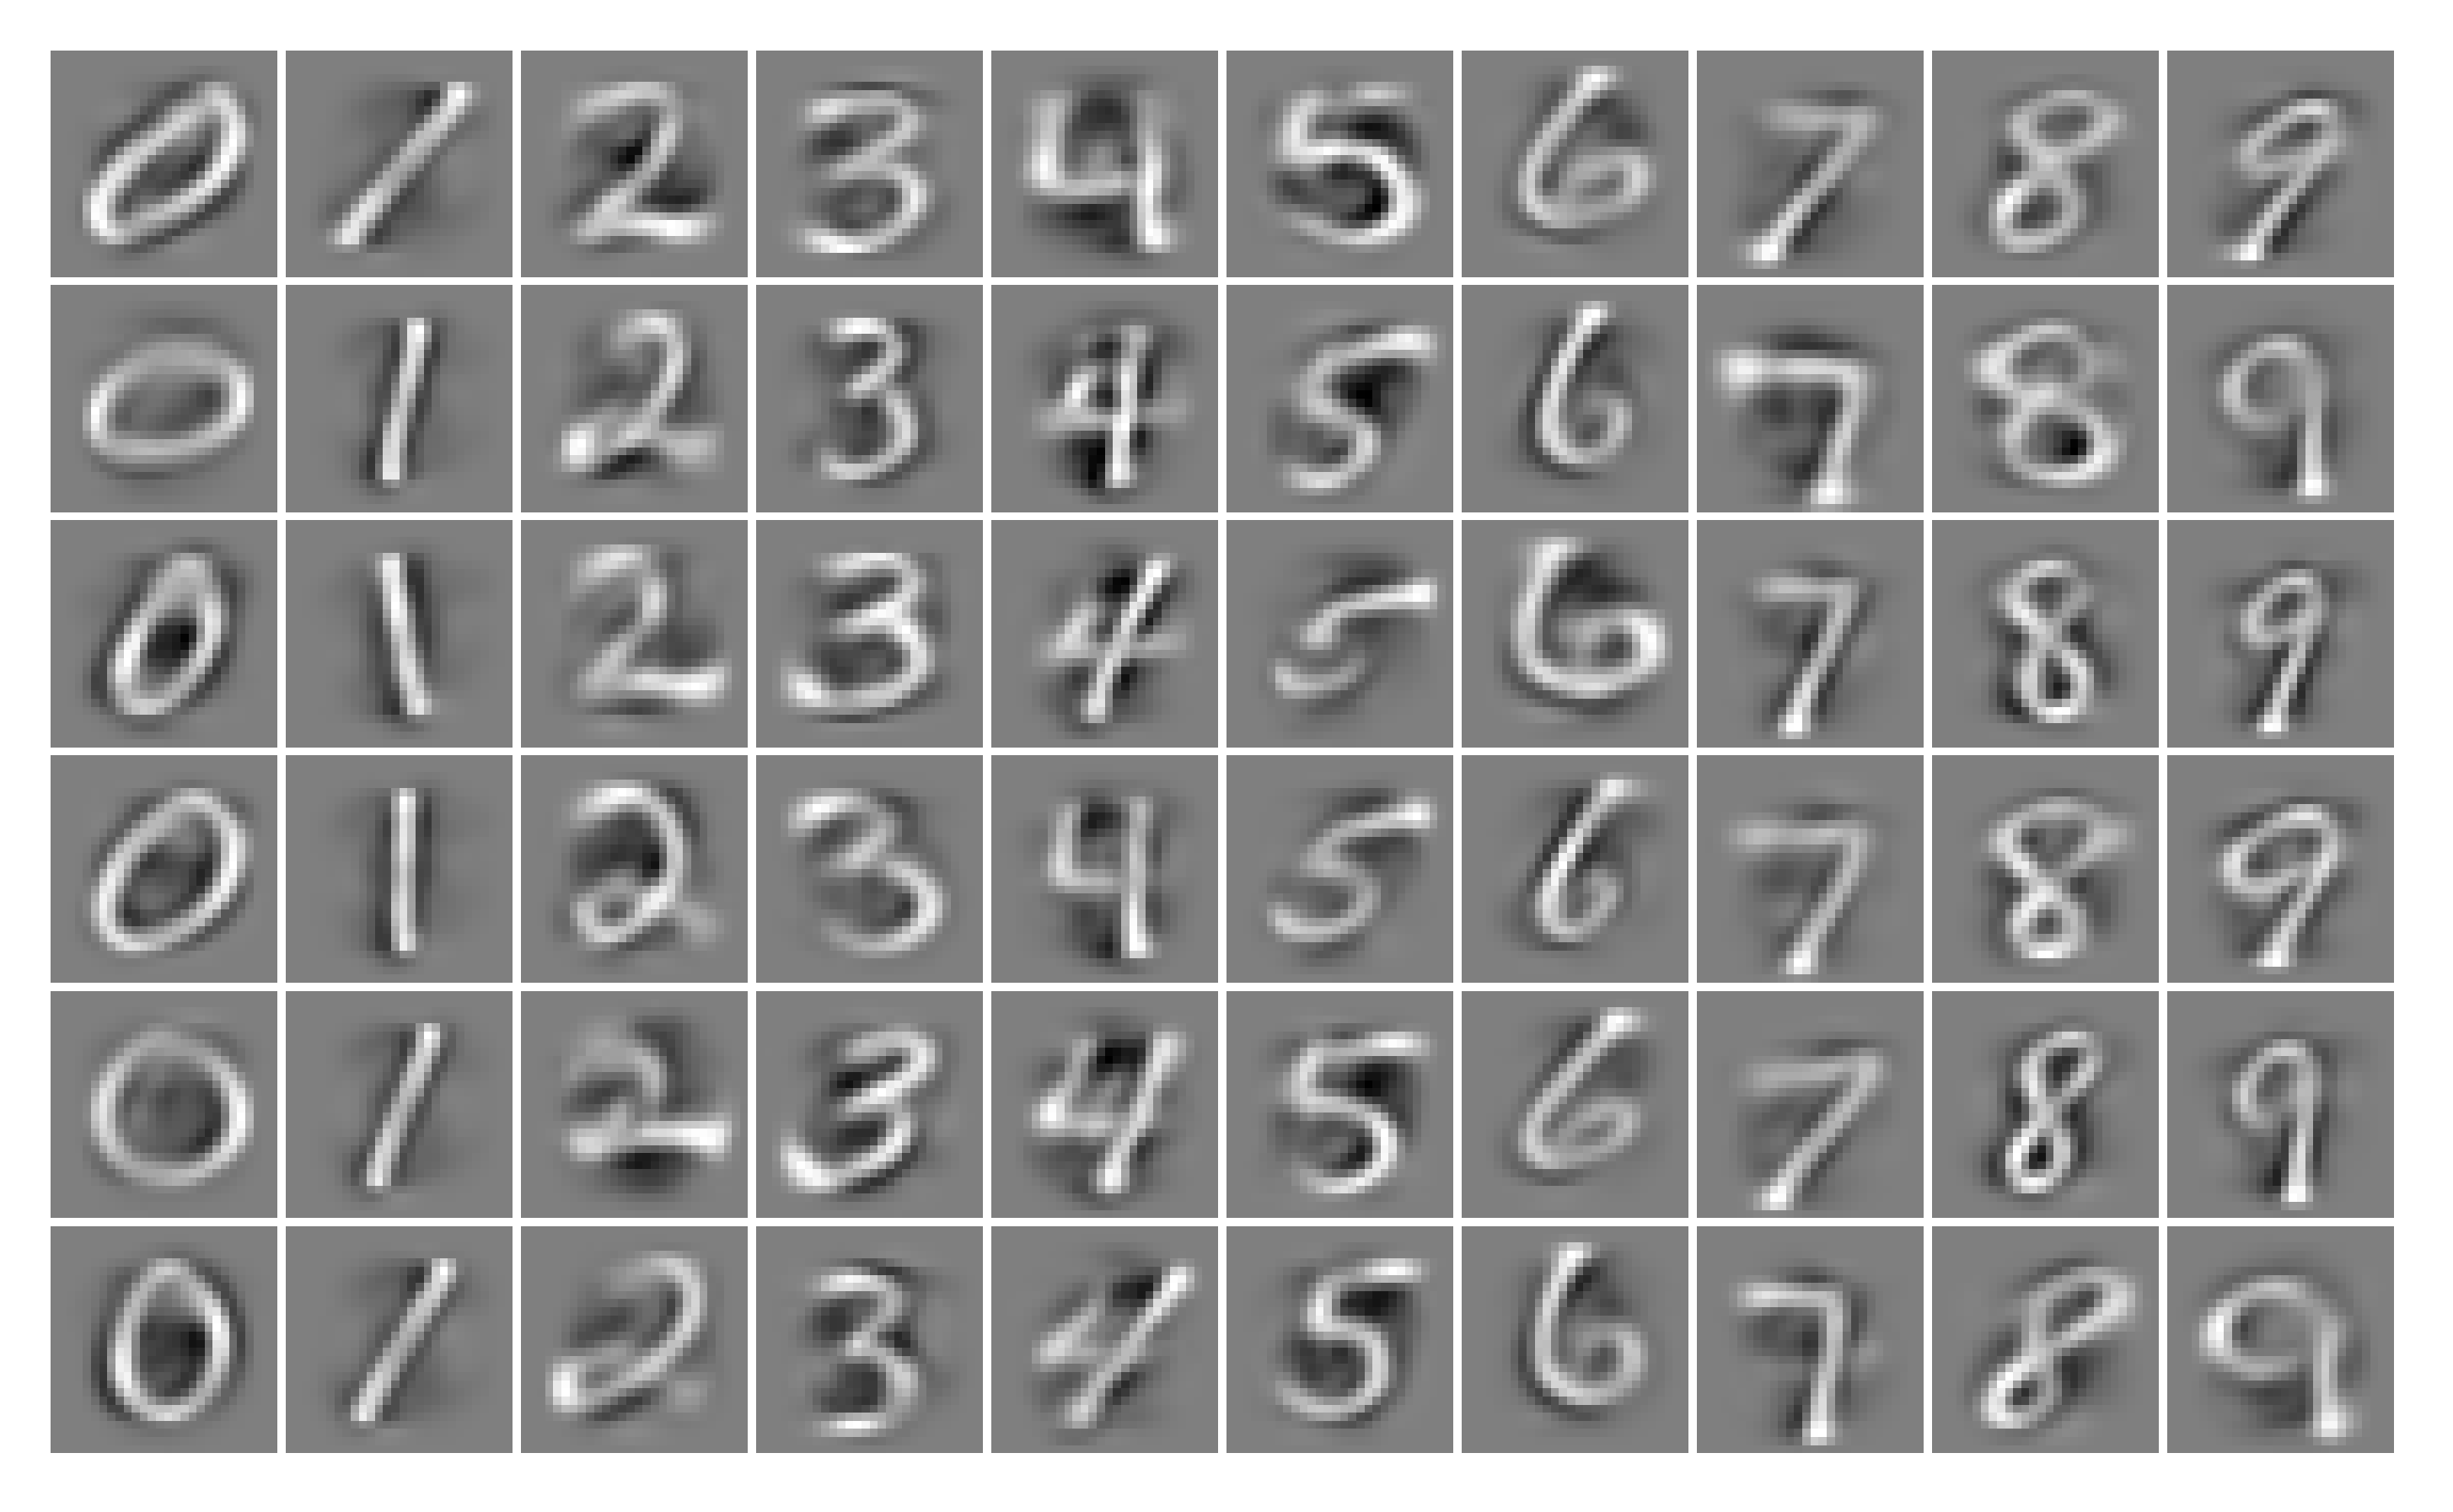

In [11]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment ('ghiasi_lstsq', S2='St', reg=1,  options=options)

### Solvers based on Singular Value Decomposition

In scikit-learn 0.21.3, erroneously, S2=Sw is used with sovler='svd'.
solver='svd' works only with S2=St.

solver =  svd  regularions parameter =  1
lda.fitFeatureExtractor took time:  6.725237607955933
Objective:  7.3476791545255296
Objective(SecondMethod):  7.3476791542127655
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  259.4772071838379
Accuracy of Nearest Neighbor classifier is:  0.9724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  7.164925813674927
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145


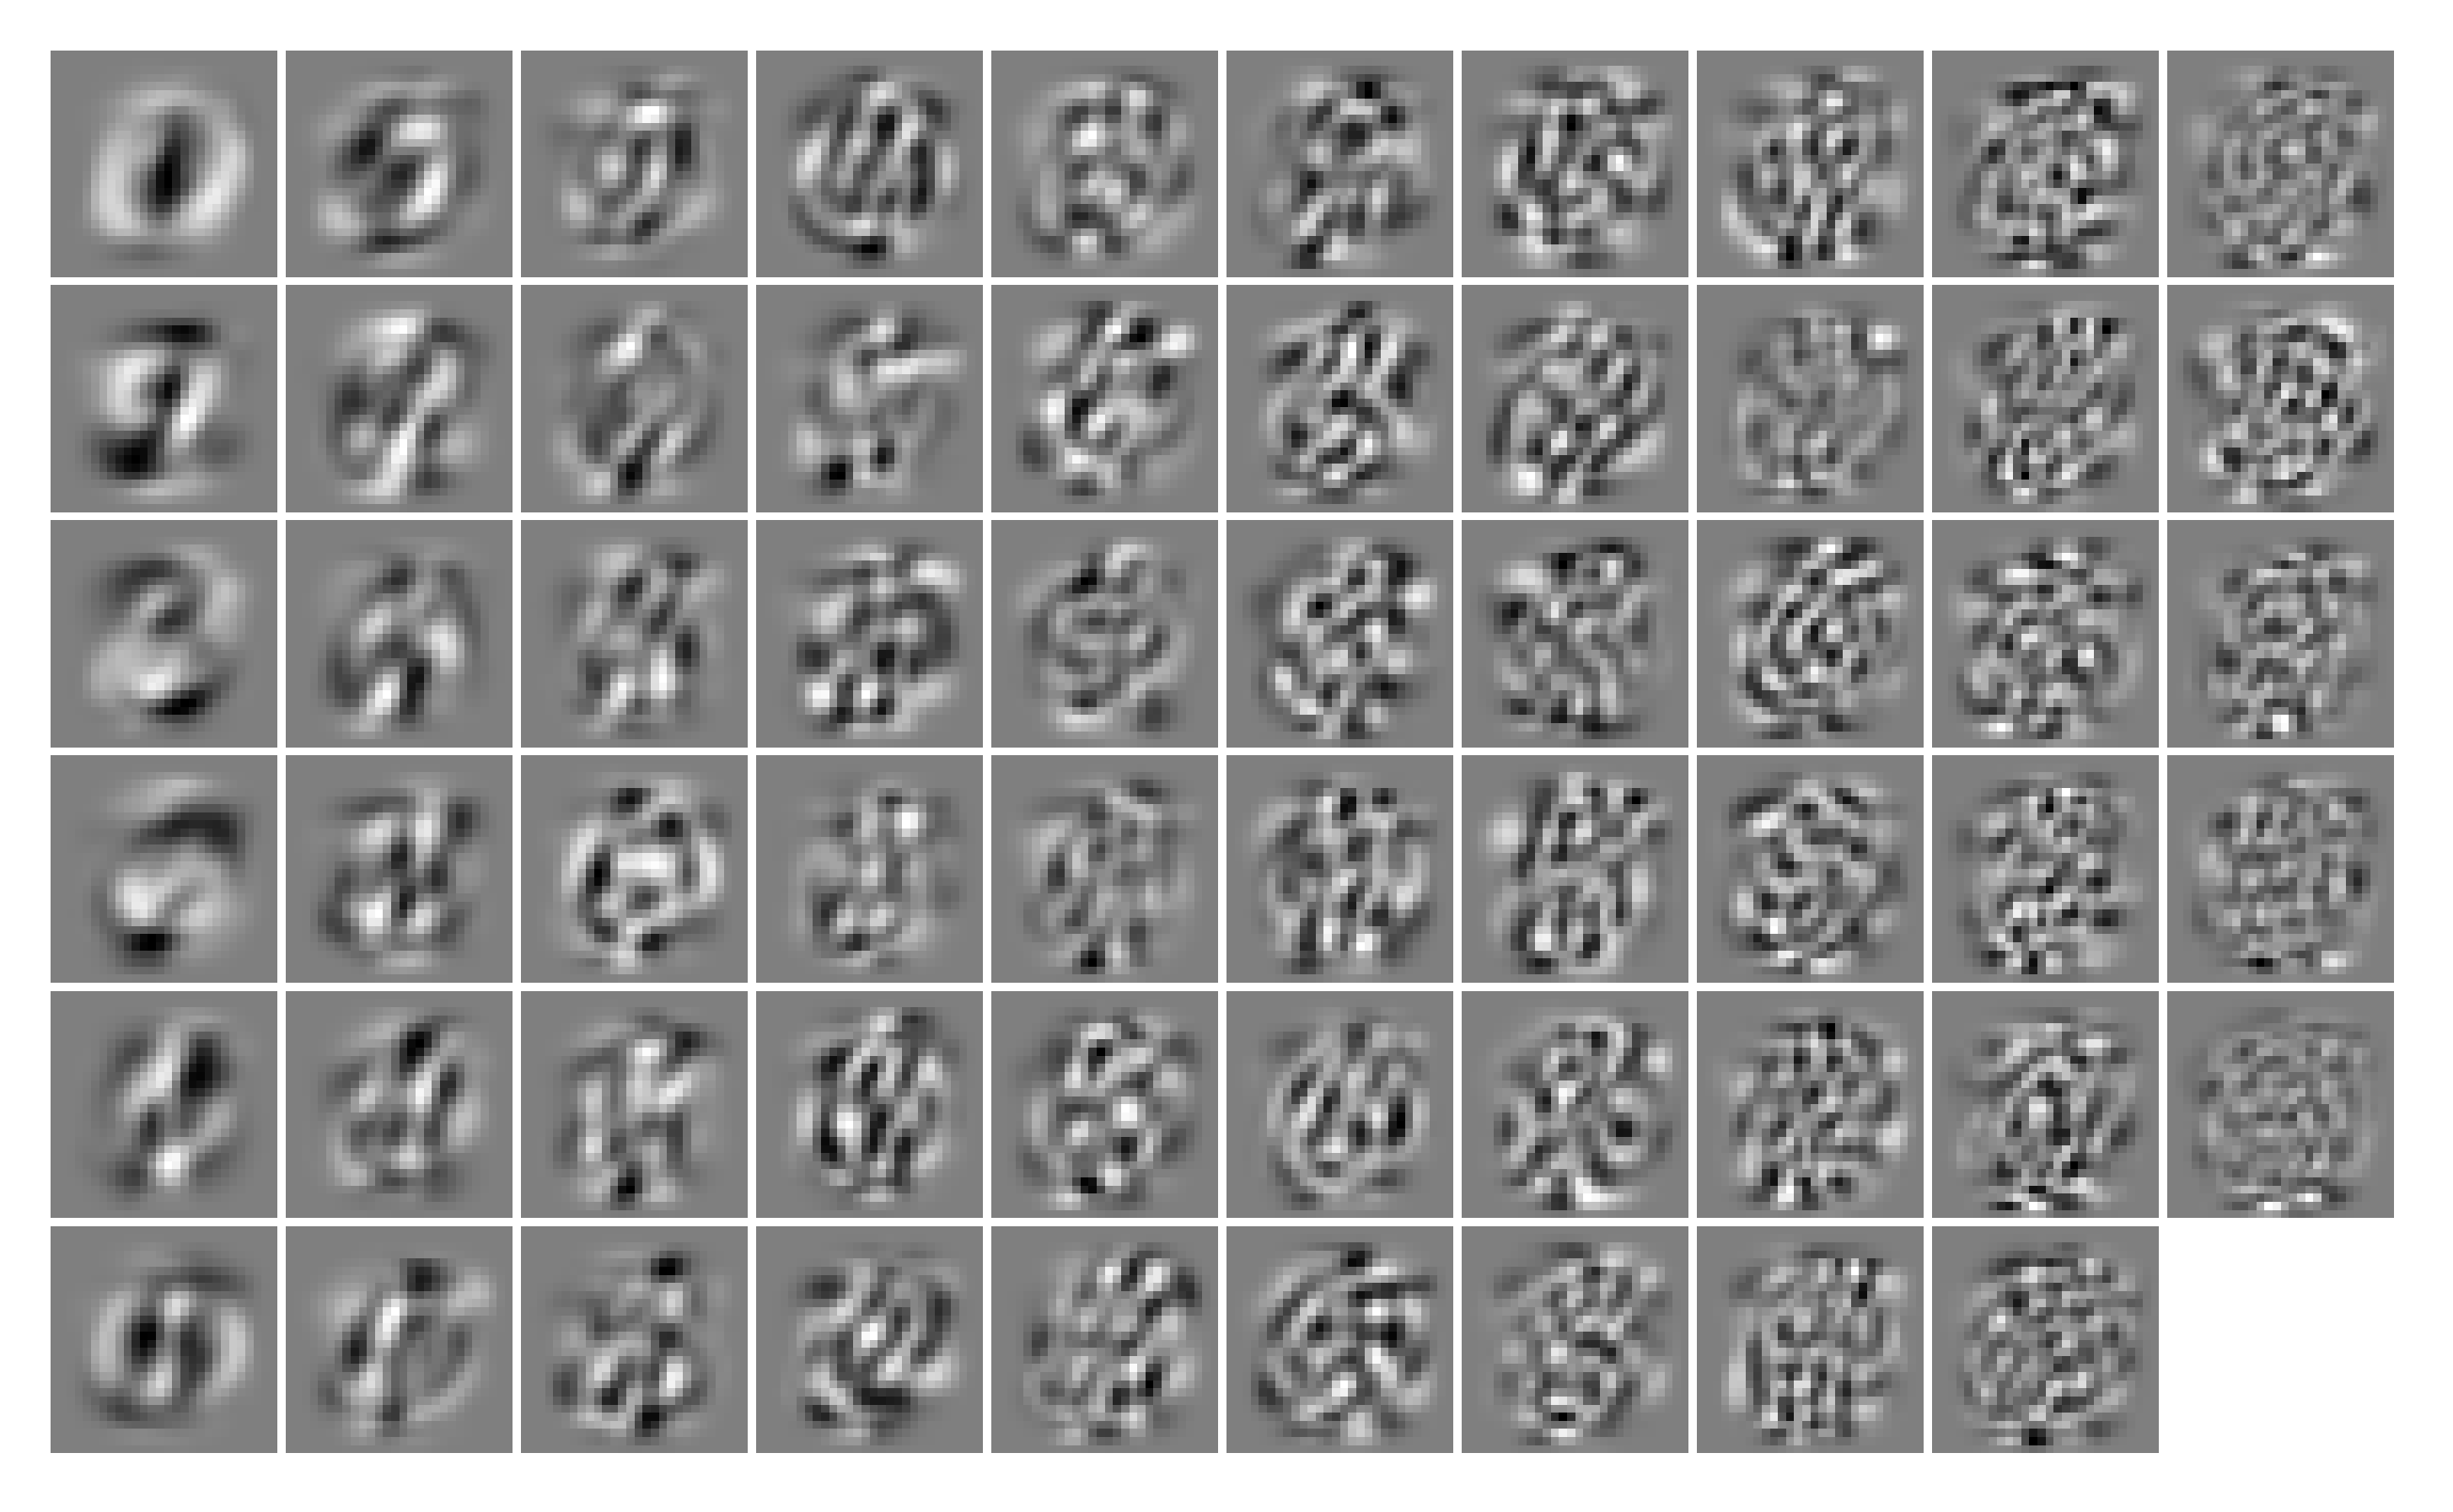

In [12]:
performExperiment ('svd', S2='St',reg = 1, options=options)

solver =  ghiasi_svd  regularions parameter =  1
lda.fitFeatureExtractor took time:  6.679655075073242
Objective:  7.347679154525585
Objective(SecondMethod):  7.34767915368208
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  260.2027313709259
Accuracy of Nearest Neighbor classifier is:  0.9709
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  7.194728374481201
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145


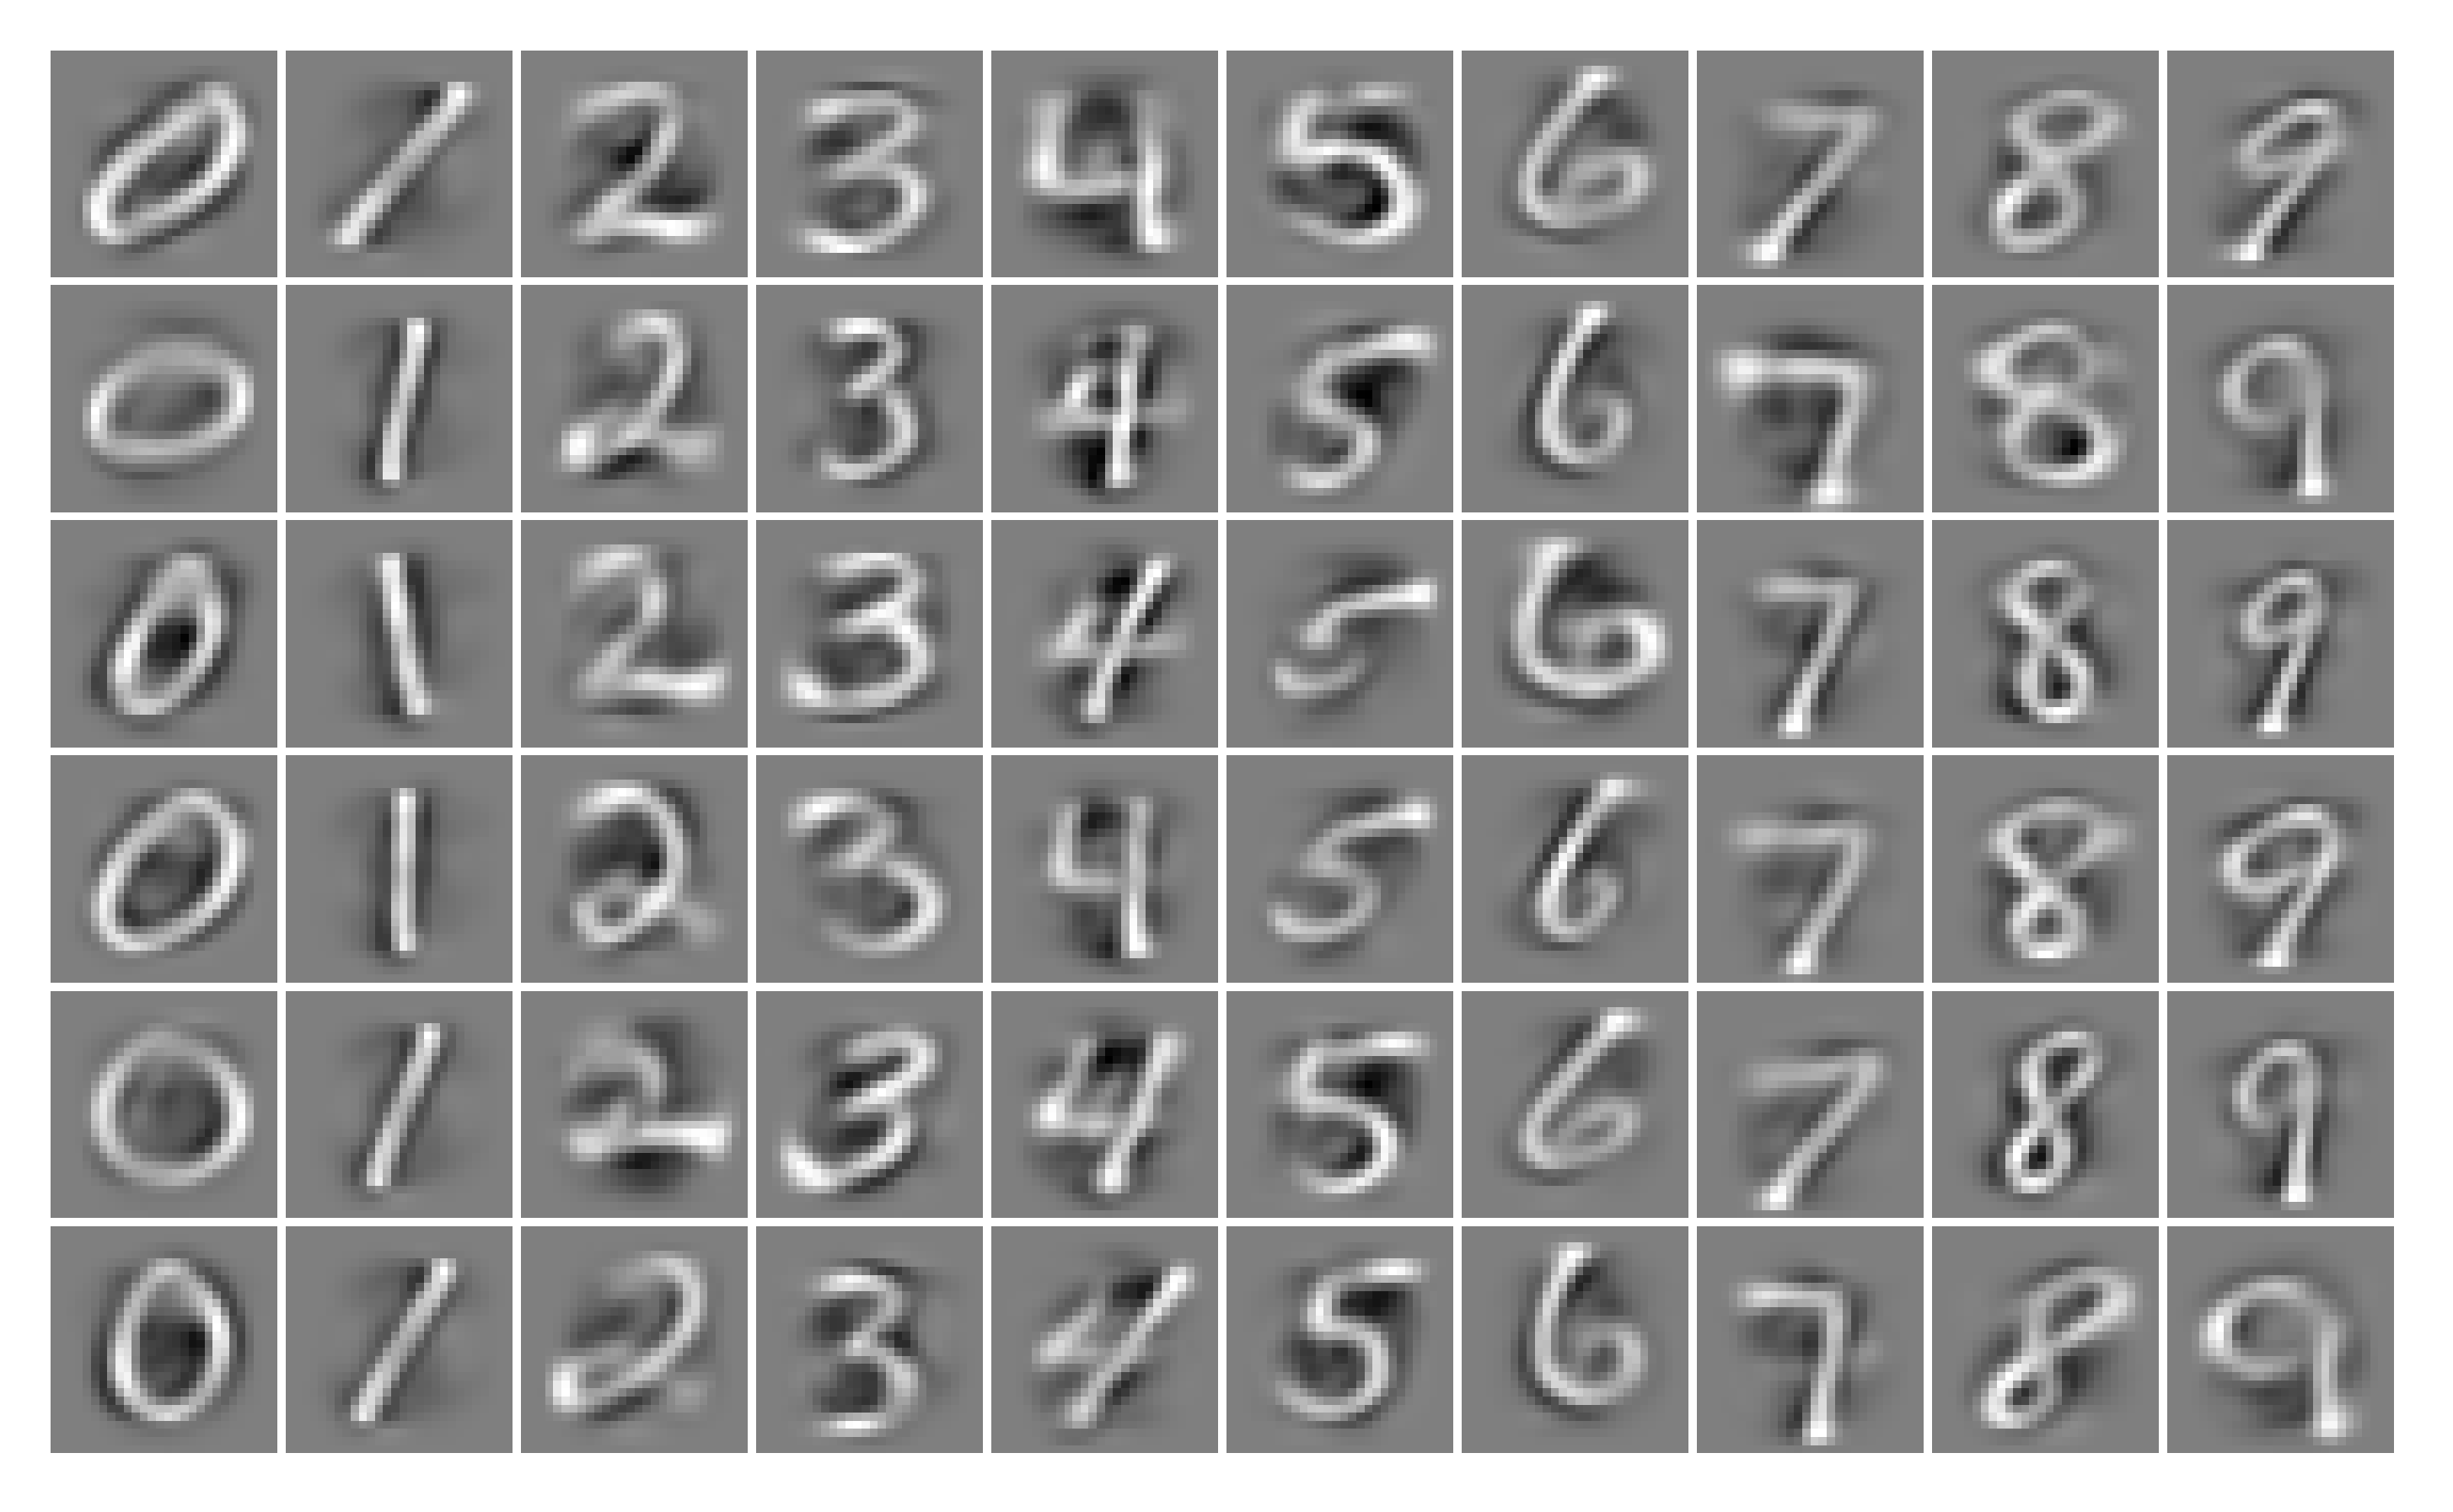

In [13]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment ('ghiasi_svd', S2='St', reg = 1,  options=options)

solver =  orthogonal_centroid  regularions parameter =  1
lda.fitFeatureExtractor took time:  0.0
Objective:  7.332591194752516
Objective(SecondMethod):  7.3325911944424575
***Classification results based on Nearest Neighbor classifier***
classification by NearestNeighbor took time:  257.29182958602905
Accuracy of Nearest Neighbor classifier is:  0.9726
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.6786234378814697
Test classification error: 0.9193
***Classification results based on max output***
Test classification error: 0.9145


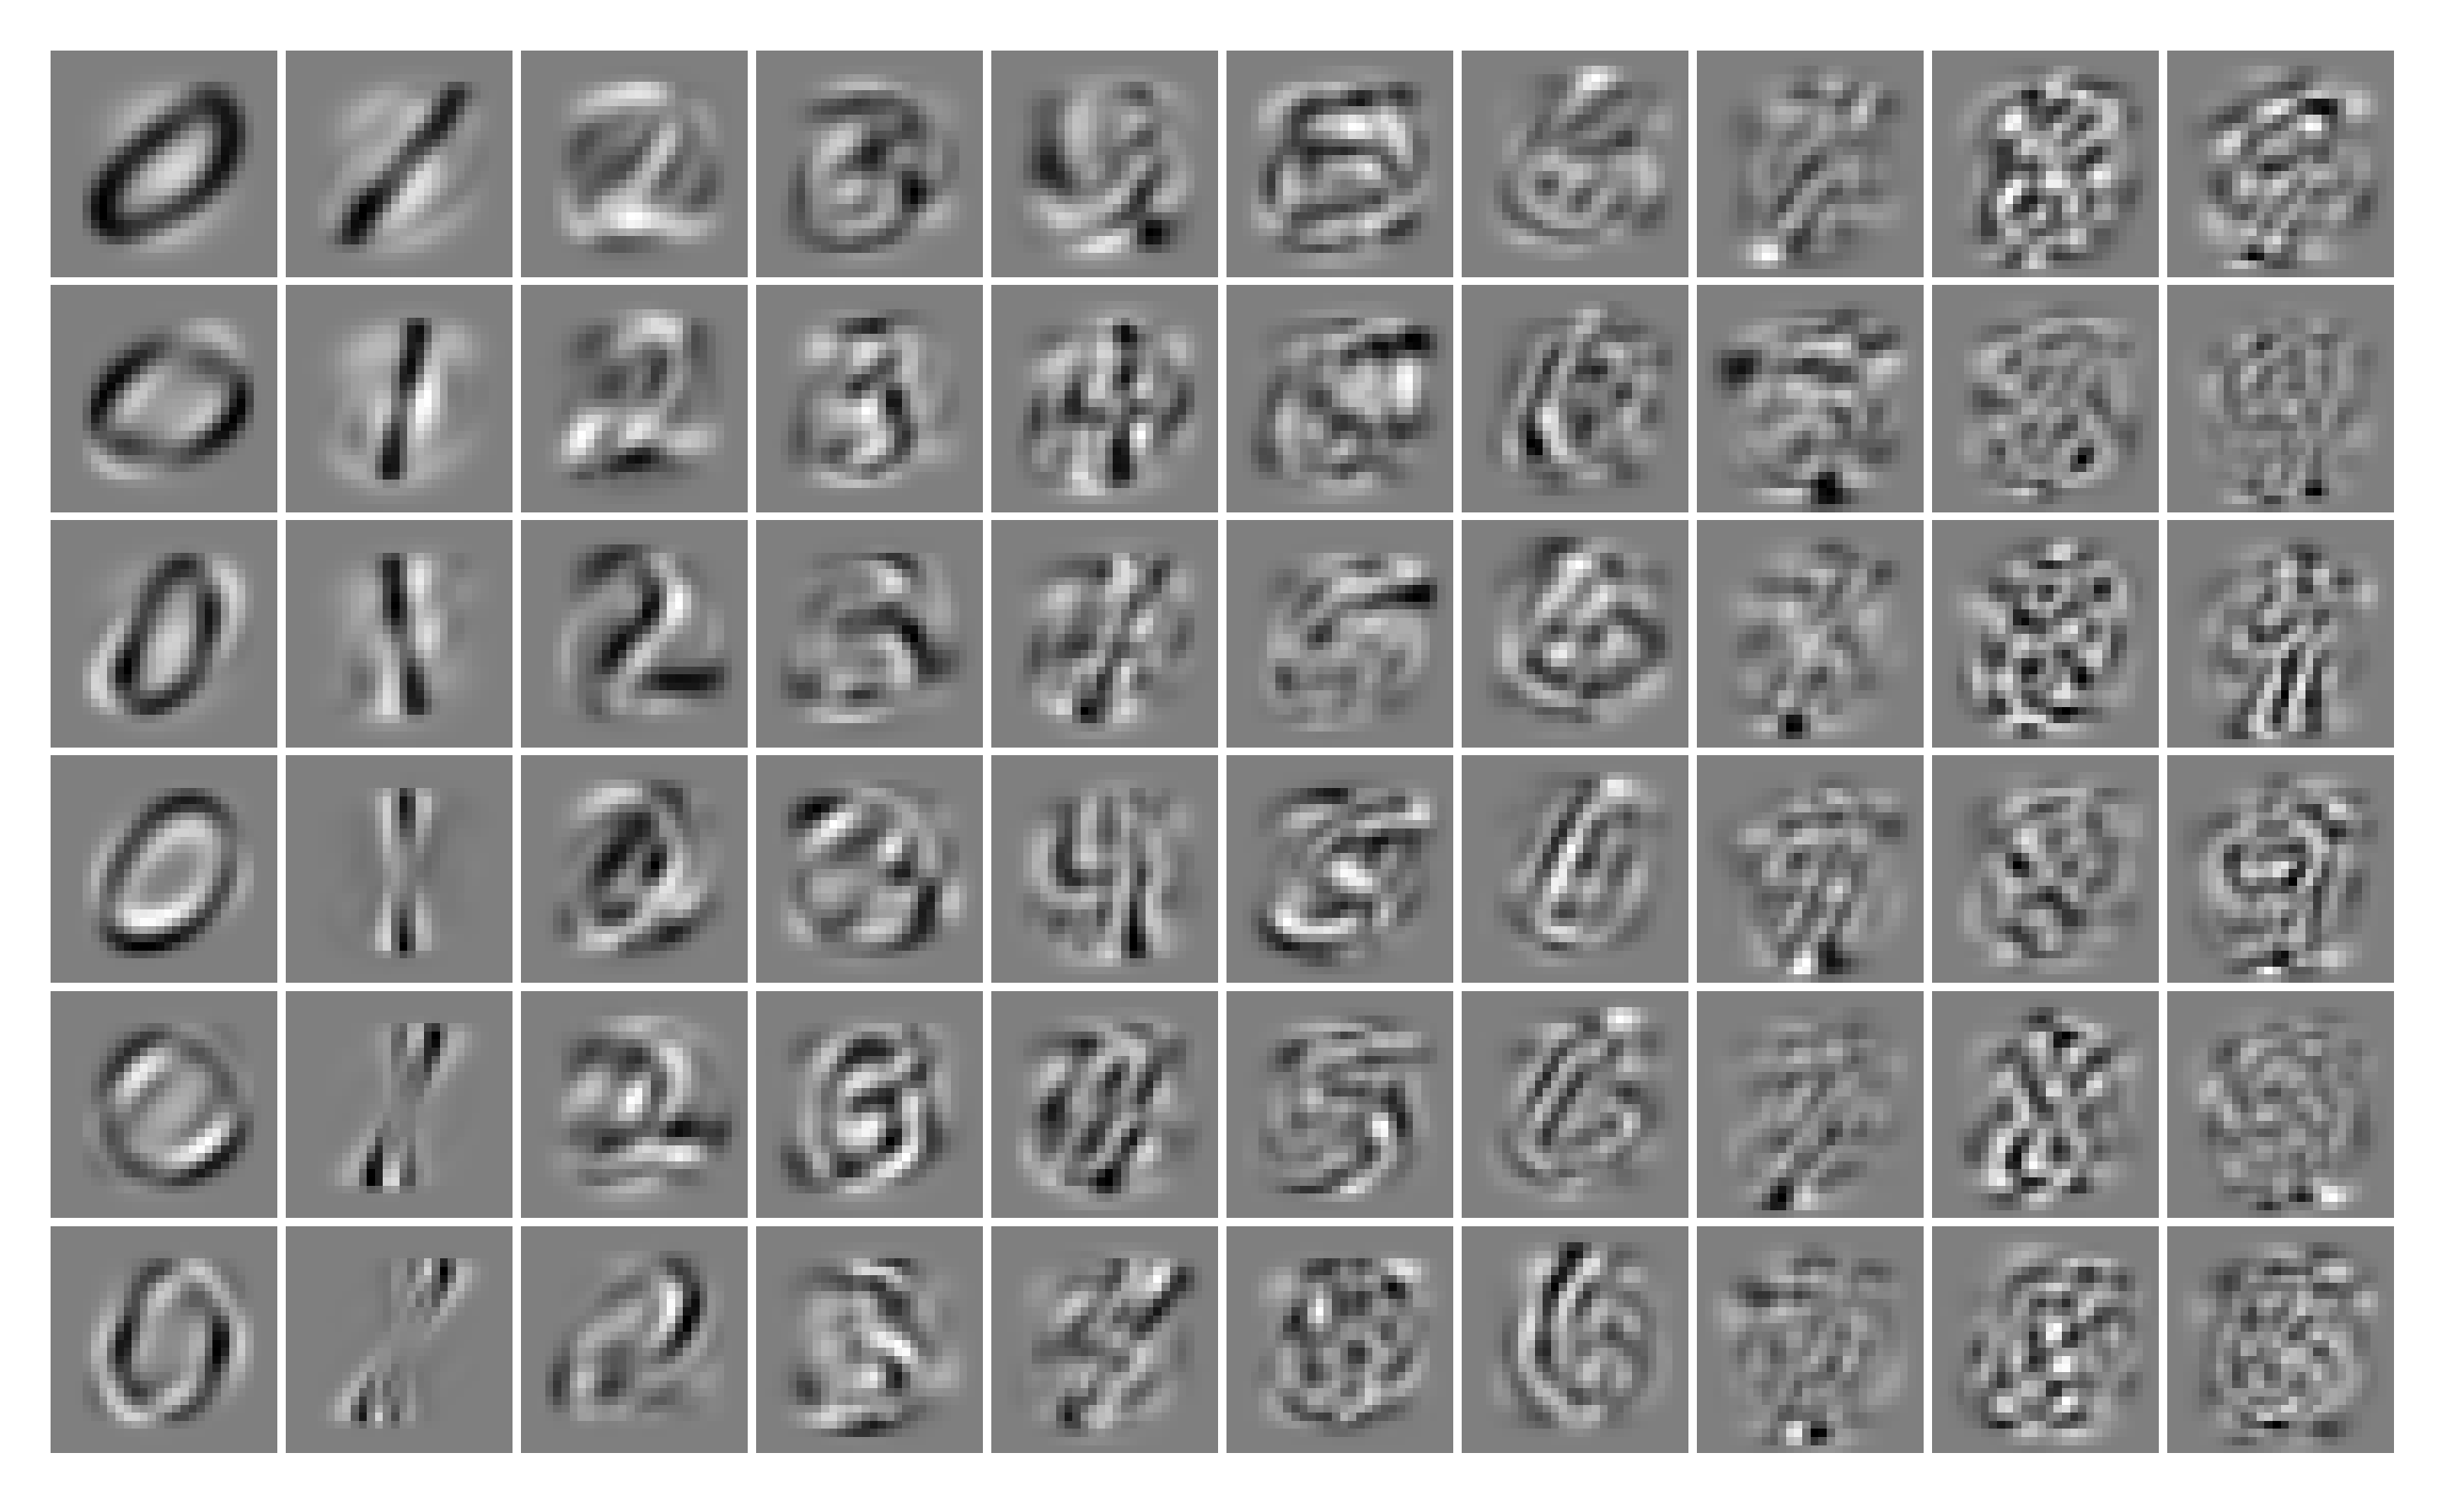

In [14]:
options = ['NN', 'Bayes', 'Max', 'Depict']
performExperiment ('orthogonal_centroid', S2='St', reg = 1,  options=options)

Note that the sligt difference in objective value compared with 'eigen' and 'lstsq' solvers stems from the regularization value which in 'svd' is applied only to non-zero diagonal elements and the fact that different numerical solvers (e.g. 'svd', 'lstsq', and 'eigen') yield sightly different solutions. 

### Running solvers with regularization paramater = 1e-10
We use a very small regularization value to ensure that solver='eigen' works.

In [15]:
#sovler='eigen' does not work with very low regularization parameters.
# So, instead of 1e-10, here we use 1e-4
options = ['Bayes', 'Max']
performExperiment ('eigen', S2='St', reg=1e-4,  options=options)

solver =  eigen  regularions parameter =  0.0001
lda.fitFeatureExtractor took time:  1.7684948444366455
Objective:  18.452016501105955
Objective(SecondMethod):  18.45201644562724
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.6225135326385498
Test classification error: 0.8833
***Classification results based on max output***
Test classification error: 0.8824


In [16]:
#solver='lstsq' is much more accurate
performExperiment ('ghiasi_lstsq', S2='St', reg=1e-10,  options=options)

solver =  ghiasi_lstsq  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  1.866100549697876
Objective:  18.570588290796294
Objective(SecondMethod):  18.570513977429894
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  1.6444175243377686
Test classification error: 0.8818
***Classification results based on max output***
Test classification error: 0.8814


In [17]:
performExperiment ('svd', S2='St',reg = 1e-10,  options=options)

solver =  svd  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  6.755337953567505
Objective:  18.57049536766583
Objective(SecondMethod):  18.570477766868933
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  7.25231409072876
Test classification error: 0.8819
***Classification results based on max output***
Test classification error: 0.8814


In [18]:
performExperiment ('ghiasi_svd', S2='St', reg = 1e-10,  options=options)

solver =  ghiasi_svd  regularions parameter =  1e-10
lda.fitFeatureExtractor took time:  6.80359673500061
Objective:  18.570495367665842
Objective(SecondMethod):  18.570447899231542
***Classification results based on Bayes optimal classifier***
lda.classifyByBayesLinearClassifier took time:  7.255098104476929
Test classification error: 0.8819
***Classification results based on max output***
Test classification error: 0.8814


### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>